Optimizando colsample_bytree para: Scale Pos Weight...
Optimizando colsample_bytree para: SMOTE + Tomek...
Optimizando colsample_bytree para: SMOTE + ENN...
Optimizando colsample_bytree para: NearMiss...
Optimizando colsample_bytree para: ADASYN...


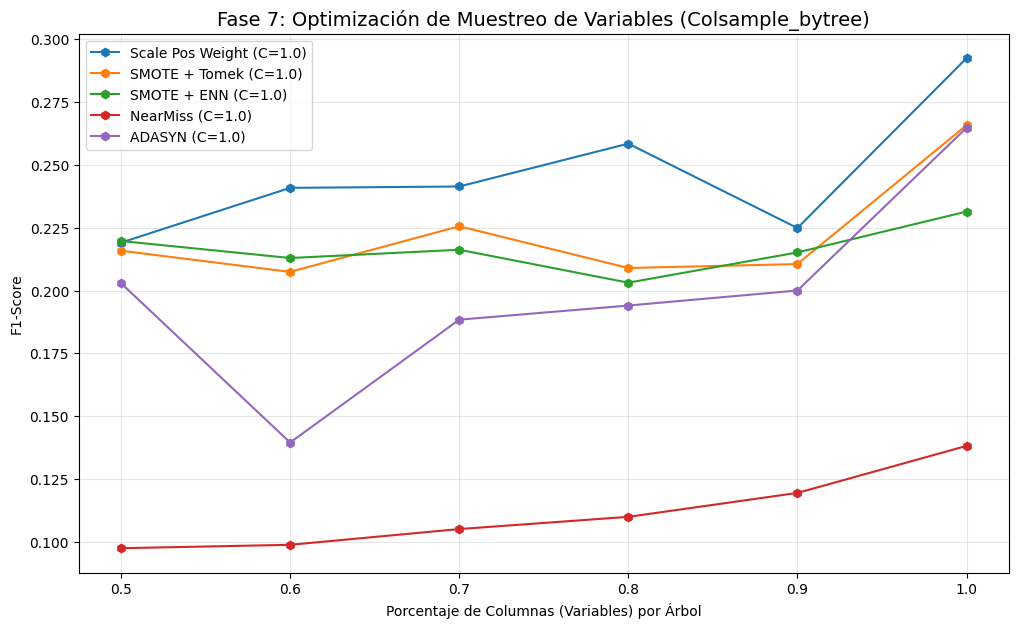


TÉCNICA              | BEST COLSAMPLE  | MAX F1  
-----------------------------------------------------------------
Scale Pos Weight     | 1.0             | 0.2924
SMOTE + Tomek        | 1.0             | 0.2657
SMOTE + ENN          | 1.0             | 0.2314
NearMiss             | 1.0             | 0.1382
ADASYN               | 1.0             | 0.2647


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import NearMiss

# 1. PREPARACIÓN DE DATOS
df = pd.read_csv('dataset/healthcare-dataset-stroke-final-scaled.csv')
df_final = pd.get_dummies(df, drop_first=True)
X = df_final.drop('stroke', axis=1)
y = df_final['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
ratio_balanceo = float(np.sum(y_train == 0) / np.sum(y_train == 1))

# 2. CONFIGURACIÓN MAESTRA (Fases 1 a 6 acumuladas)
# Estructura: {Nombre: (Sampler, n_est, lr, depth, child_w, gamma, subsample)}
config_fase6 = {
    'Scale Pos Weight': (None, 125, 0.1, 5, 1, 0, 0.9),
    'SMOTE + Tomek': (SMOTETomek(random_state=42), 256, 0.15, 5, 3, 0.1, 1.0),
    'SMOTE + ENN': (SMOTEENN(random_state=42), 171, 0.1, 5, 1, 0, 0.8),
    'NearMiss': (NearMiss(), 271, 0.001, 4, 1, 0, 1.0),
    'ADASYN': (ADASYN(random_state=42), 242, 0.15, 5, 1, 0, 1.0)
}

colsample_range = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
final_results = []

plt.figure(figsize=(12, 7))

for nombre, (sampler, n_opt, lr_opt, d_opt, w_opt, g_opt, s_opt) in config_fase6.items():
    cols_f1 = []
    
    # Aplicar el balanceo correspondiente
    if nombre == 'Scale Pos Weight':
        X_res, y_res = X_train, y_train
        spw = ratio_balanceo
    else:
        X_res, y_res = sampler.fit_resample(X_train, y_train)
        spw = 1
        
    print(f"Optimizando colsample_bytree para: {nombre}...")
    
    for c in colsample_range:
        model = XGBClassifier(
            n_estimators=n_opt,
            learning_rate=lr_opt,
            max_depth=d_opt,
            min_child_weight=w_opt,
            gamma=g_opt,
            subsample=s_opt,
            colsample_bytree=c,
            scale_pos_weight=spw,
            random_state=42,
            n_jobs=-1,
            eval_metric='logloss'
        )
        model.fit(X_res, y_res)
        y_pred = model.predict(X_test)
        cols_f1.append(f1_score(y_test, y_pred))
    
    # Guardar el mejor resultado de esta técnica
    max_f1 = max(cols_f1)
    best_c = colsample_range[cols_f1.index(max_f1)]
    final_results.append({
        'Técnica': nombre,
        'Best Colsample': best_c,
        'Max F1': max_f1
    })
    
    plt.plot(colsample_range, cols_f1, marker='h', label=f"{nombre} (C={best_c})")

plt.title('Fase 7: Optimización de Muestreo de Variables (Colsample_bytree)', fontsize=14)
plt.xlabel('Porcentaje de Columnas (Variables) por Árbol')
plt.ylabel('F1-Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 3. TABLA COMPARATIVA FINAL
print("\n" + "="*65)
print(f"{'TÉCNICA':<20} | {'BEST COLSAMPLE':<15} | {'MAX F1':<8}")
print("-"*65)
for r in final_results:
    print(f"{r['Técnica']:<20} | {r['Best Colsample']:<15} | {r['Max F1']:.4f}")
print("="*65)